In [14]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import joblib as jb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Load your preprocessed dataset
df = pd.read_csv('./Preprocessed/preprocessed_air_quality_data.csv')

# Drop non-numeric and target columns from features
target_col = 'PM10_MAX'
drop_cols = [target_col, 'NAME', 'LASTUPDATEDATETIME', 'timestamp']
drop_cols = [col for col in drop_cols if col in df.columns]
features = df.drop(columns=drop_cols)
target = df[target_col]

print(f"Features shape: {features.shape}")
print(f"Target shape: {target.shape}")

Features shape: (103205, 23)
Target shape: (103205,)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
xgb_model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

In [7]:
xgb_model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, feature_weights=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None, ...)

In [8]:
y_pred_train = xgb_model.predict(X_train_scaled)
y_pred_val = xgb_model.predict(X_test_scaled)

In [9]:
# Evaluate the model on the training and validation sets
train_mae = mean_absolute_error(y_train, y_pred_train)
train_mse = mean_squared_error(y_train, y_pred_train)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_pred_train)
validation_mae = mean_absolute_error(y_test, y_pred_val)
validation_mse = mean_squared_error(y_test, y_pred_val)
validation_rmse = np.sqrt(validation_mse)
validation_r2 = r2_score(y_test, y_pred_val)
print(f"Train MAE: {train_mae}, Train RMSE: {train_rmse}, Train R2: {train_r2:2f}")
print(f"Validation MAE: {validation_mae}, Validation RMSE: {validation_rmse}, Validation R2: {validation_r2:2f}")

Train MAE: 0.0019674940586495225, Train RMSE: 0.0028857299305518284, Train R2: 0.999843
Validation MAE: 0.002673381389090797, Validation RMSE: 0.004369236868713198, Validation R2: 0.999647


In [21]:
tscv = TimeSeriesSplit(n_splits=5)
scores_r2 = cross_val_score(xgb_model, features, target, scoring='r2', cv=tscv)
score_mae = cross_val_score(xgb_model, features, target, scoring='neg_mean_absolute_error', cv=tscv)
score_rmse = cross_val_score(xgb_model, features, target, scoring='neg_root_mean_squared_error', cv=tscv)

print(f"Mean TimeSeries CV R²: {np.mean(scores_r2):.4f} ± {np.std(scores_r2):.4f}")
print(f"Mean TimeSeries CV MAE: {-np.mean(score_mae):.4f} ± {np.std(score_mae):.4f}")
print(f"Mean TimeSeries CV RMSE: {-np.mean(score_rmse):.4f} ± {np.std(score_rmse):.4f}")

Mean TimeSeries CV R²: 0.9290 ± 0.0471
Mean TimeSeries CV MAE: 0.0301 ± 0.0081
Mean TimeSeries CV RMSE: 0.0492 ± 0.0187


In [11]:
jb.dump(xgb_model, 'models/xgb_regressor.pkl')

['models/xgb_regressor.pkl']

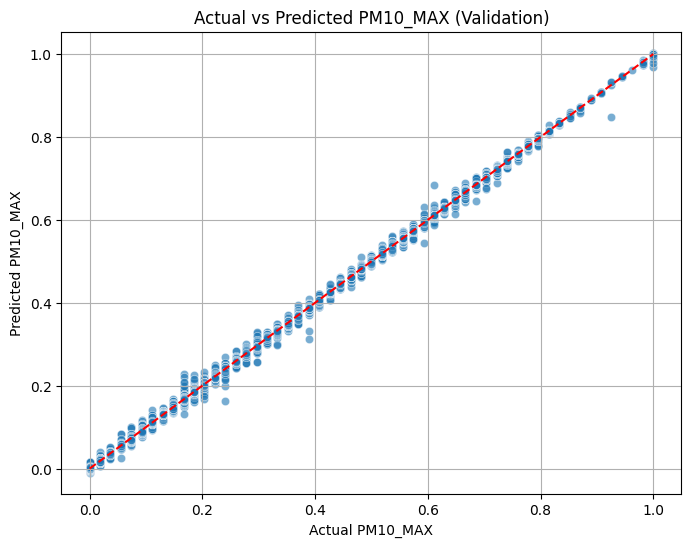

In [15]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_val, alpha=0.6)
plt.xlabel("Actual PM10_MAX")
plt.ylabel("Predicted PM10_MAX")
plt.title("Actual vs Predicted PM10_MAX (Validation)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.grid(True)
plt.show()

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
from tabulate import tabulate

# Define helper function
def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

# Get train and validation metrics
train_metrics = regression_metrics(y_train, y_pred_train)
val_metrics = regression_metrics(y_test, y_pred_val)

# Put them in a DataFrame
metrics_df = pd.DataFrame({
    'MAE': [train_metrics[0], val_metrics[0],-np.mean(score_mae)],
    'RMSE': [train_metrics[1], val_metrics[1],-np.mean(score_rmse)],
    'R² Score': [train_metrics[2], val_metrics[2],np.mean(scores_r2)]
}, index=['Train', 'Validation','TSCV'])

# Print as a table using tabulate
print(tabulate(metrics_df.round(3), headers='keys', tablefmt='pretty'))


+------------+-------+-------+----------+
|            |  MAE  | RMSE  | R² Score |
+------------+-------+-------+----------+
|   Train    | 0.002 | 0.003 |   1.0    |
| Validation | 0.003 | 0.004 |   1.0    |
|    TSCV    | 0.03  | 0.049 |  0.929   |
+------------+-------+-------+----------+


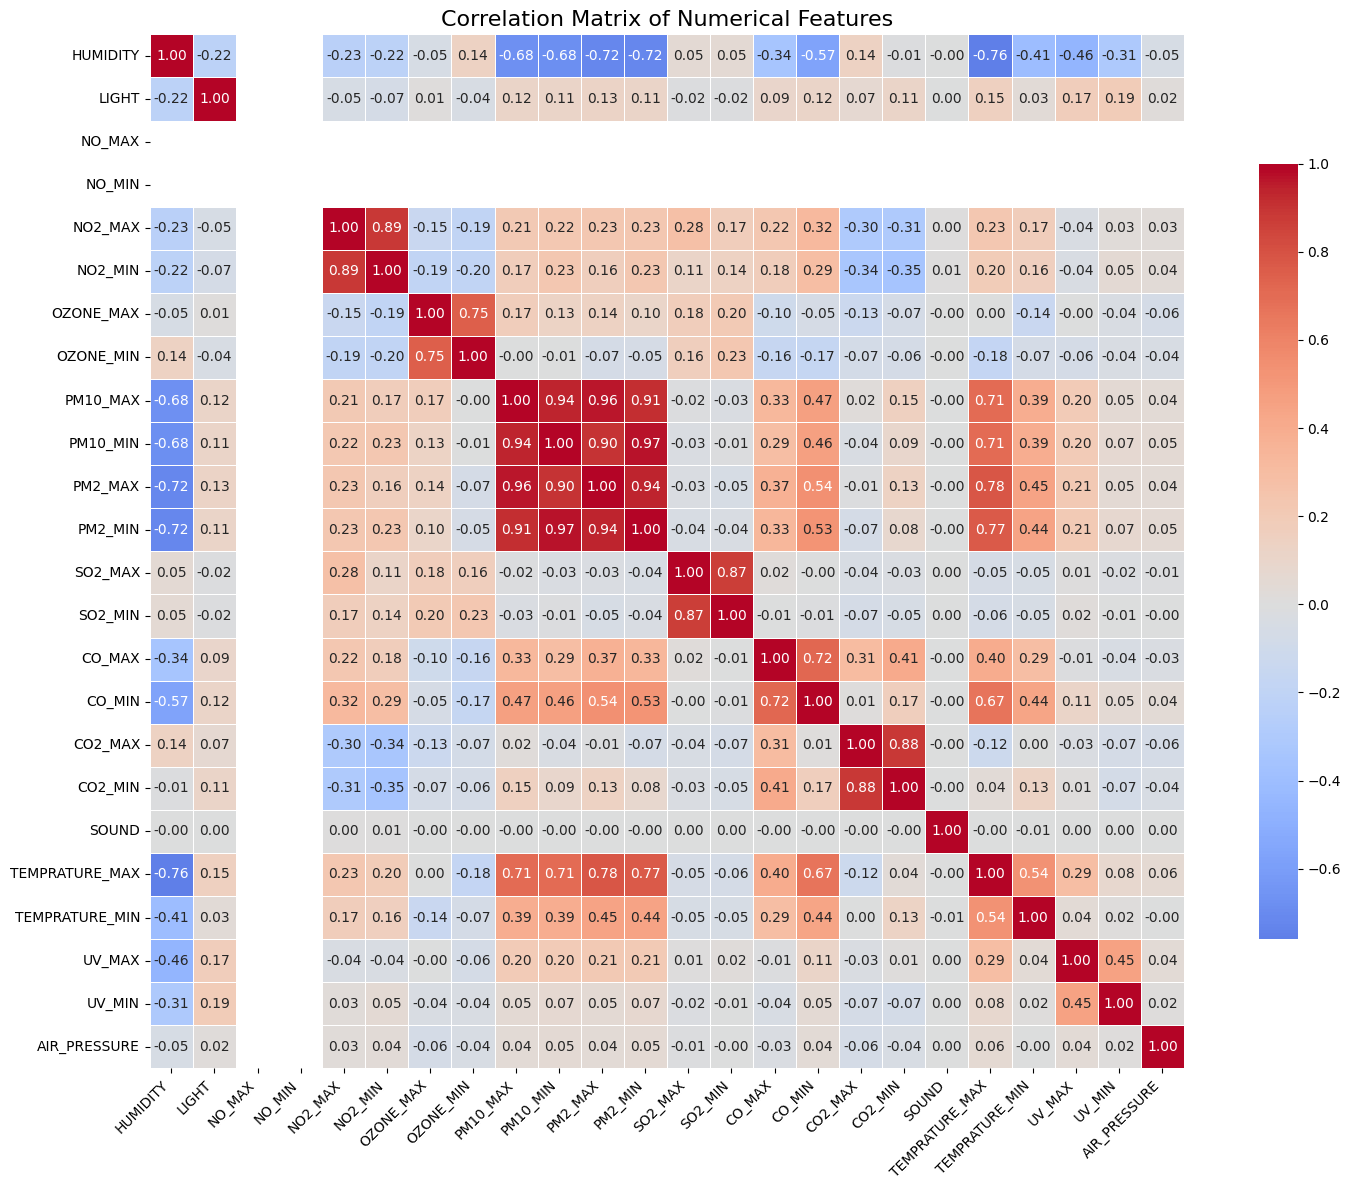

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation matrix
corr_matrix = df.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0,
            cbar_kws={"shrink": .75}, square=True, linewidths=0.5)

plt.title("Correlation Matrix of Numerical Features", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [24]:
pm10_corr = corr_matrix['PM10_MAX'].sort_values(ascending=False)
print("Top correlations with PM10_MAX:\n")
print(pm10_corr)

Top correlations with PM10_MAX:

PM10_MAX          1.000000
PM2_MAX           0.959988
PM10_MIN          0.936109
PM2_MIN           0.911552
TEMPRATURE_MAX    0.709737
CO_MIN            0.466917
TEMPRATURE_MIN    0.392315
CO_MAX            0.326515
NO2_MAX           0.213494
UV_MAX            0.197820
OZONE_MAX         0.172778
NO2_MIN           0.169960
CO2_MIN           0.148125
LIGHT             0.117618
UV_MIN            0.046097
AIR_PRESSURE      0.039811
CO2_MAX           0.020628
OZONE_MIN        -0.000537
SOUND            -0.002533
SO2_MAX          -0.016643
SO2_MIN          -0.027285
HUMIDITY         -0.676142
NO_MAX                 NaN
NO_MIN                 NaN
Name: PM10_MAX, dtype: float64
